In [1]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torchvision.transforms.functional as cvF

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def gaussian_noise(image_tensor: torch.Tensor, mean=0.0, std=0.1):
    noise = torch.randn(image_tensor.size(), device=device) * std + mean
    noisy_image = image_tensor + noise
    
    return torch.clamp(noisy_image, 0, 1)

In [3]:
image = Image.open("img1.png")
image = transforms.ToTensor()(image)[0:3]

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale()
])

image = transform(image).to(device).unsqueeze(0)

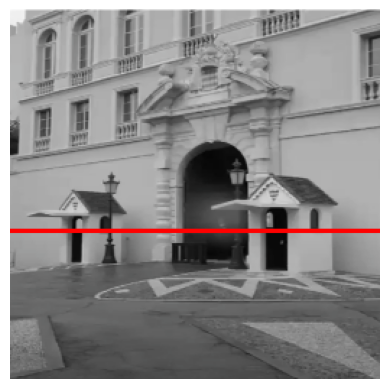

In [4]:
_, _, height, width = image.shape

y_pos = height // 2 +25

cv_image = cv2.resize(cv2.imread('img1.png'), (256, 256))
cv_image = cv2.line(cv_image, (0, y_pos), (width, y_pos), (255, 0, 0), 2)

plt.imshow(cv_image)
plt.axis('off')
plt.show()

### Get Intensity Profile

The intensity graph displays how light or dark each pixel is in a grayscale image. By taking the derivative of that graph, all of the peaks and valleys are edges from a group of light pixels to a group of dark pixels or vice versa

In [5]:
def intensity_profile(image_tensor: torch.Tensor, y_pos: int):
    line = image_tensor[0][0][y_pos]
    y = line.cpu().numpy()
    x = np.linspace(0, len(y)-1, len(y))

    d_kernel = torch.tensor([-1, 1], device=device, dtype=torch.float)
    dy = F.conv1d(image_tensor[0][0][y_pos].unsqueeze(0), d_kernel.unsqueeze(0).unsqueeze(0))
    dy = F.pad(dy, (0, 1), mode='constant', value=0)
    dy = dy.squeeze().cpu().numpy()

    return x, y, dy

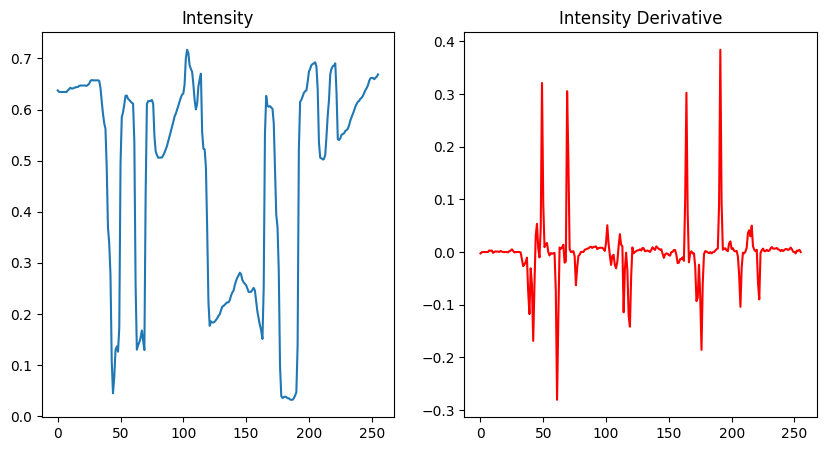

In [6]:
x, y, dy = intensity_profile(image, y_pos)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x, y)
plt.title('Intensity')

plt.subplot(1, 2, 2)
plt.plot(x, dy, color='r')
plt.title('Intensity Derivative')

plt.show();

Adding noise to the image can make it harder to identify the edges from the intensity profile since there are more drastic changes from light to dark and vice versa

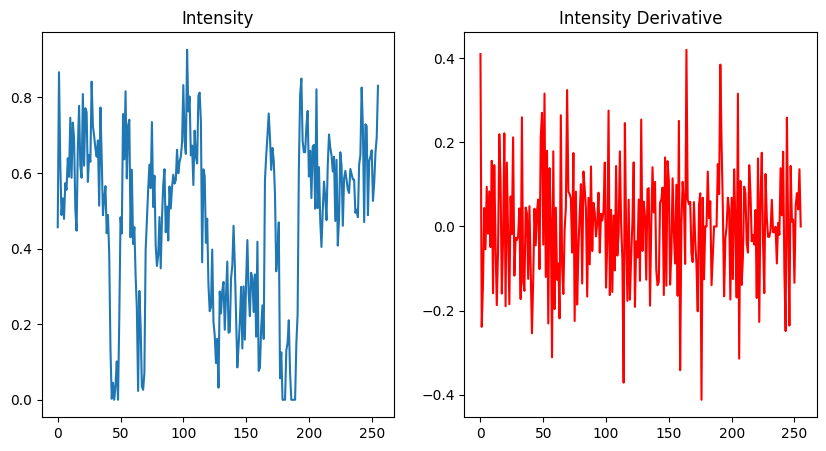

In [7]:
noisy_image_tensor = gaussian_noise(image)
x, y, dy = intensity_profile(noisy_image_tensor, y_pos)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x, y)
plt.title('Intensity')

plt.subplot(1, 2, 2)
plt.plot(x, dy, color='r')
plt.title('Intensity Derivative')
plt.show();

By applying a gaussian filter to smooth the image, the noise can be removed and the resulting intensity profile not only shows the edges again but looks very similar to the starting intensity profile

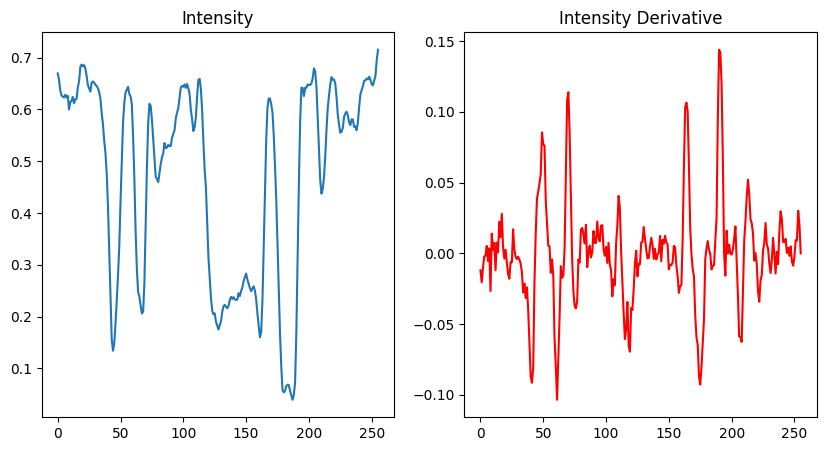

In [8]:
smoothed_noisy_image_tensor = cvF.gaussian_blur(noisy_image_tensor, kernel_size=5, sigma=2)
x, y, dy = intensity_profile(smoothed_noisy_image_tensor, y_pos)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x, y)
plt.title('Intensity')

plt.subplot(1, 2, 2)
plt.plot(x, dy, color='r')
plt.title('Intensity Derivative')
plt.show();

In [9]:
x = torch.tensor([[1, 1, 1], [1, 1, 1], [1, 1, 1]])
y = torch.tensor([1, 0, -1])

x * y

tensor([[ 1,  0, -1],
        [ 1,  0, -1],
        [ 1,  0, -1]])

### Prewitt Edge Detection

Edges in $x$ direction
1. Smooth the image with a convolution with kernel, $\begin{bmatrix} 1 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 1 & 1 \end{bmatrix}$
2. Apply derivative in $x$ direction with a convolution with kernel, $\begin{bmatrix} 1 & 0 & -1 \end{bmatrix}$

Edges in $y$ direction
1. Smooth the image with a convolution with kernel, $\begin{bmatrix} 1 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 1 & 1 \end{bmatrix}$
2. Apply derivative in $y$ direction with a convolution with kernel, $\begin{bmatrix} 1 \\ 0 \\ -1 \end{bmatrix}$

Hadamard product can be used to combine the two steps.

The gradient (edge) magnitude can be found with the equation: $edges = \sqrt{edges_x^2 + edges_y^2}$

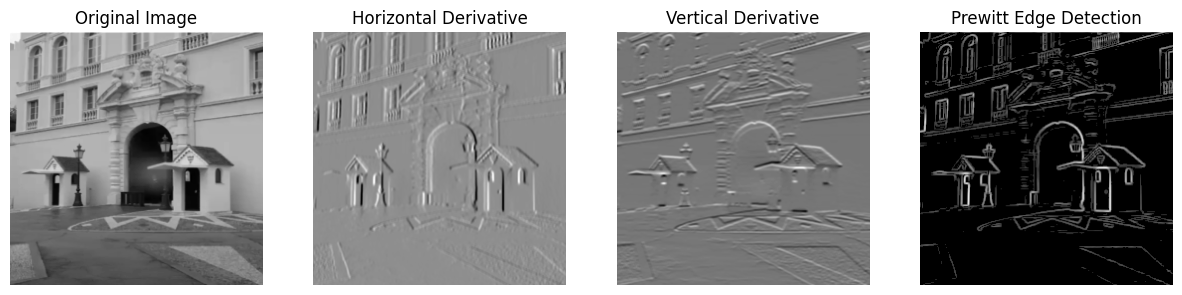

In [10]:
kernel_x = torch.tensor(
    [[1, 0, -1], [1, 0, -1], [1, 0, -1]],
    dtype=torch.float, device=device
).view(1, 1, 3, 3)
kernel_y = torch.tensor(
    [[1, 1, 1], [0, 0, 0], [-1, -1, -1]],
    dtype=torch.float, device=device
).view(1, 1, 3, 3)

edges_x = F.conv2d(image, kernel_x)
edges_y = F.conv2d(image, kernel_y)
edges = torch.sqrt(edges_x ** 2 + edges_y ** 2)

edges = F.threshold(edges, 0.3, 0)

edges_x = edges_x.squeeze().cpu().numpy()
edges_y = edges_y.squeeze().cpu().numpy()
edges = edges.squeeze().cpu().numpy()

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(image.squeeze().cpu().numpy(), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(edges_x, cmap='gray')
plt.title('Horizontal Derivative')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(edges_y, cmap='gray')
plt.title('Vertical Derivative')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(edges, cmap='gray')
plt.title('Prewitt Edge Detection')
plt.axis('off')

plt.show()

### Sobel Edge Detection

Edges in $x$ direction
1. Smooth the image with a convolution with kernel, $\begin{bmatrix} 1 & 1 & 1 \\ 2 & 2 & 2 \\ 1 & 1 & 1 \end{bmatrix}$
2. Apply derivative in $x$ direction with a convolution with kernel, $\begin{bmatrix} 1 & 0 & -1 \end{bmatrix}$

Edges in $y$ direction
1. Smooth the image with a convolution with kernel, $\begin{bmatrix} 1 & 2 & 1 \\ 1 & 2 & 1 \\ 1 & 2 & 1 \end{bmatrix}$
2. Apply derivative in $y$ direction with a convolution with kernel, $\begin{bmatrix} 1 \\ 0 \\ -1 \end{bmatrix}$

Hadamard product can be used to combine the two steps.

The gradient (edge) magnitude can be found with the following equation
$$edges = \sqrt{edges_x^2 + edges_y^2}$$

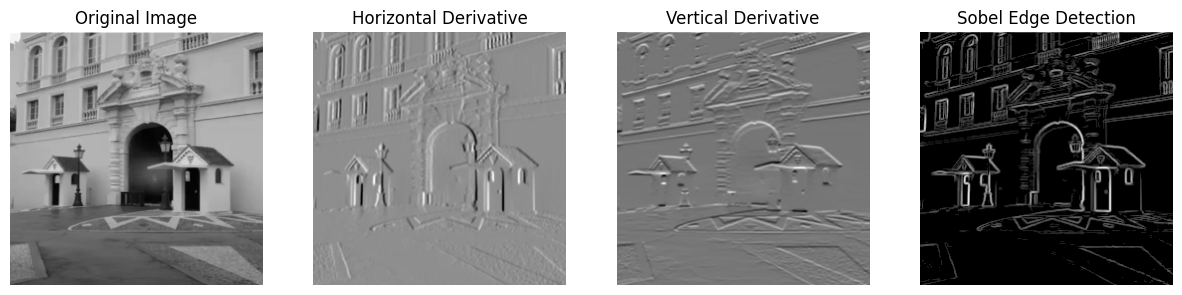

In [11]:
kernel_x = torch.tensor([[1, 0, -1],
                       [2, 0, -2],
                       [1, 0, -1]], dtype=torch.float, device=device)
kernel_y = torch.tensor([[1, 2, 1],
                       [0, 0, 0],
                       [-1, -2, -1]], dtype=torch.float, device=device)

edges_x = F.conv2d(image, kernel_x.view(1, 1, 3, 3))
edges_y = F.conv2d(image, kernel_y.view(1, 1, 3, 3))
edges = torch.sqrt(edges_x ** 2 + edges_y ** 2)

edges = F.threshold(edges, 0.3, 0)

edges_x = edges_x.squeeze().cpu().numpy()
edges_y = edges_y.squeeze().cpu().numpy()
edges = edges.squeeze().cpu().numpy()

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(image.squeeze().cpu().numpy(), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(edges_x, cmap='gray')
plt.title('Horizontal Derivative')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(edges_y, cmap='gray')
plt.title('Vertical Derivative')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(edges, cmap='gray')
plt.title('Sobel Edge Detection')
plt.axis('off')

plt.show()

### Marr Hildreth Edge Detection

1. Smooth image with Gaussian filter
2. Apply Laplacian of Gaussian (LoG)
$$\Delta ^2 g(x, y)=-\frac{1}{\sqrt{2\pi}\sigma ^3}\Big( 2-\frac{x^2+y^2}{\sigma ^2} \Big)e^{-\frac{x^2+y^2}{2\sigma ^2}}$$
3. Find zery crossings

In [12]:
def laplacian_of_gaussian(image_tensor: torch.Tensor, kernel_size: int, sigma: float) -> torch.Tensor:
    # Apply Gaussian smoothing
    smoothed_image_tensor = cvF.gaussian_blur(image_tensor, kernel_size, sigma)

    # Apply Laplacian of Gaussian
    x = torch.arange(kernel_size, dtype=torch.float, device=device) - kernel_size // 2
    y = torch.arange(kernel_size, dtype=torch.float, device=device) - kernel_size // 2
    x, y = torch.meshgrid(x, y)
    normalization = 1 / (2.0 * np.pi * sigma**2)
    log_kernel = normalization * ((x**2 + y**2 - 2.0 * sigma**2) / (sigma**4)) * torch.exp(-(x**2 + y**2) / (2.0 * sigma**2))
    log_kernel = log_kernel - log_kernel.mean()
    log_kernel = log_kernel.unsqueeze(0).unsqueeze(0)
    log_image_tensor = F.conv2d(smoothed_image_tensor, log_kernel, padding=kernel_size // 2)

    return log_image_tensor.squeeze(0)

def zero_crossing(log_image_tensor):
    zero_crossings = torch.zeros_like(log_image_tensor)
    zero_crossings[:, 1:-1, 1:-1] = (
        (log_image_tensor[:, 1:-1, 1:-1] * log_image_tensor[:, :-2, 1:-1] < 0) |
        (log_image_tensor[:, 1:-1, 1:-1] * log_image_tensor[:, 2:, 1:-1] < 0) |
        (log_image_tensor[:, 1:-1, 1:-1] * log_image_tensor[:, 1:-1, :-2] < 0) |
        (log_image_tensor[:, 1:-1, 1:-1] * log_image_tensor[:, 1:-1, 2:] < 0)
    ).float()

    return zero_crossings.squeeze()


/Users/davidrobinson/Documents/GitHub/LearningPortfolio/.venv/lib/python3.11/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


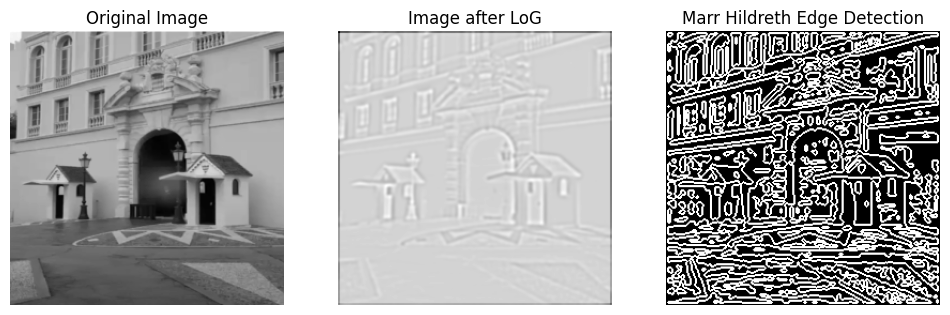

In [13]:
smoothed_image_tensor = cvF.gaussian_blur(image, kernel_size=5, sigma=1)
log_image_tensor = laplacian_of_gaussian(smoothed_image_tensor, 5, 1)
edges = zero_crossing(log_image_tensor)

log_image = log_image_tensor.squeeze(0).cpu().numpy()
edges = edges.squeeze(0).cpu().numpy()

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image.squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Image after LoG")
plt.imshow(log_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Marr Hildreth Edge Detection")
plt.imshow(edges, cmap='gray')
plt.axis('off')

plt.show()

### Canny Edge Detection

1. Smooth image with Gaussian filter
2. Compute gradiant magnitude and orientation
3. Apply non-max suppression
4. Apply thresholding

In [14]:
def compute_gradients(image):
    kernel_x = torch.tensor(
        [[1, 0, -1], [2, 0, -2], [1, 0, -1]], 
        dtype=torch.float, device=device
    ).view(1, 1, 3, 3)
    kernel_y = torch.tensor(
        [[1, 2, 1], [0, 0, 0], [-1, -2, -1]],
        dtype=torch.float, device=device
    ).view(1, 1, 3, 3)

    # Compute gradients in x and y direction
    grad_x = F.conv2d(image, kernel_x, padding=1)
    grad_y = F.conv2d(image, kernel_y, padding=1)
    
    return grad_x, grad_y

def non_max_suppression(edges, theta):
    theta = theta * 180.0 / np.pi
    theta[theta < 0] += 180
    theta = torch.remainder(theta, 180.0)

    Z = torch.zeros_like(edges, device=device, dtype=torch.float)
    
    # Define the direction ranges and neighbor offsets
    direction_ranges = [(0, 22.5), (22.5, 67.5), (67.5, 112.5), (112.5, 157.5), (157.5, 180)]
    neighbor_offsets = [((0, 1), (0, -1)),
                        ((1, 1), (-1, -1)),
                        ((1, 0), (-1, 0)),
                        ((-1, 1), (1, -1)),
                        ((0, 1), (0, -1))]
    
    edges = edges.squeeze()
    theta = theta.squeeze()
    
    # Pad edges for boundary edges
    padded_edges = F.pad(edges, (1, 1, 1, 1), mode='constant', value=0)
    
    # Iterate over direction ranges and neighbor offsets
    for (lb, ub), (offset1, offset2) in zip(direction_ranges, neighbor_offsets):
        mask = (theta >= lb) & (theta < ub)
        
        i_off1, j_off1 = offset1
        i_off2, j_off2 = offset2
        
        neighbor1 = padded_edges[1+i_off1:1+i_off1+edges.size(0), 1+j_off1:1+j_off1+edges.size(1)]
        neighbor2 = padded_edges[1+i_off2:1+i_off2+edges.size(0), 1+j_off2:1+j_off2+edges.size(1)]
        
        edge_mask = (edges >= neighbor1) & (edges >= neighbor2)
        combined_mask = mask & edge_mask
        
        Z[combined_mask.unsqueeze(0).unsqueeze(0)] = edges[combined_mask]

    return Z

def threshold_and_hysteresis(image: torch.Tensor, low_threshold=0.05, high_threshold=0.15):
    low = image > low_threshold
    high = image > high_threshold

    image = low * 0.5 + high * 0.5

    hysteresis_kernel = torch.ones((3, 3), device=device, dtype=torch.float).view(1, 1, 3, 3) + 0.25

    weak = (image == 0.5) * 1
    weak_is_high = (F.conv2d(image, hysteresis_kernel, padding=1) > 1) * weak
    image = high * 1 + weak_is_high * 1

    return image

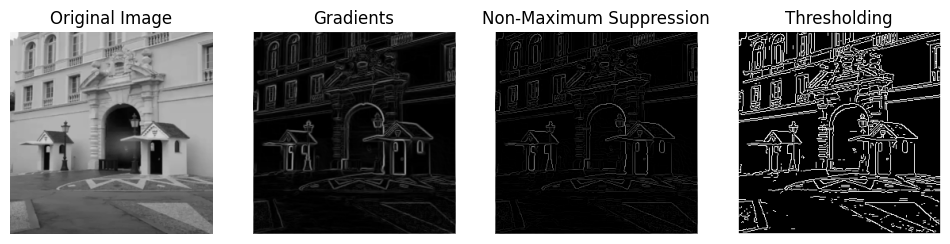

In [15]:
# Apply Gaussian blur to smooth image
smoothed_image = cvF.gaussian_blur(image, kernel_size=5, sigma=1)

# Compute gradient magnitude and orientation
grad_x, grad_y = compute_gradients(image)

grad = torch.sqrt(grad_x ** 2 + grad_y ** 2)
theta = torch.atan2(grad_y, grad_x)
grad = grad / grad.max()

# Non-Maximum Suppression
non_max_suppressed_image = non_max_suppression(grad, theta)

# Thresholding
thresholded_image = threshold_and_hysteresis(non_max_suppressed_image)

non_max_suppressed_image = non_max_suppressed_image.squeeze().cpu().numpy()
grad = grad.squeeze().cpu().numpy()
thresholded_image = thresholded_image.squeeze().cpu().numpy()

plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.title("Original Image")
plt.imshow(image.squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Gradients")
plt.imshow(grad, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Non-Maximum Suppression")
plt.imshow(non_max_suppressed_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("Thresholding")
plt.imshow(thresholded_image, cmap='gray')
plt.axis('off')

plt.show()